In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

import scipy.stats as stats
import scikit_posthocs as sp
from itertools import combinations
import statsmodels.api as sm


In [46]:
# 정규성 확인 함수
def assess_normality(series, alpha=0.05, verbose=True):
    """
    series: pandas Series (numeric)
    alpha : 기준 유의수준
    """
    s = pd.to_numeric(series, errors='coerce').dropna().values
    n = len(s)

    results = {}
    results['n'] = n

    # 왜도 / 첨도 (Fisher=True => excess kurtosis; 정규분포면 0)
    results['skew']   = stats.skew(s, bias=False)
    results['kurt_excess'] = stats.kurtosis(s, fisher=True, bias=False)

    # D’Agostino K^2
    k2_stat, k2_p = stats.normaltest(s)
    results['dagostino_k2'] = k2_stat
    results['dagostino_p']  = k2_p

    # Jarque–Bera
    jb_stat, jb_p = stats.jarque_bera(s)
    results['jarque_bera'] = jb_stat
    results['jarque_bera_p'] = jb_p

    # Anderson–Darling (임계값 비교)
    ad_res = stats.anderson(s, dist='norm')
    results['anderson_stat'] = ad_res.statistic
    # AD는 p가 아니라 임계값 제공
    results['anderson_crit'] = dict(zip(ad_res.significance_level, ad_res.critical_values))

    # Lilliefors KS (statsmodels)
    ks_stat, ks_p = sm.stats.diagnostic.kstest_normal(s)
    results['lilliefors_stat'] = ks_stat
    results['lilliefors_p'] = ks_p

    # 실무적 판단 (단순 규칙)
    skew_ok  = abs(results['skew']) < 0.5
    kurt_ok  = abs(results['kurt_excess']) < 1
    practical_normal = skew_ok and kurt_ok

    results['practical_normal'] = practical_normal

    if verbose:
        print(f"표본 수 n = {n}")
        print(f"왜도 skew (정규분포 0) = {results['skew']:.3f}")
        print(f"초과 첨도 excess kurtosis (정규분포 0) = {results['kurt_excess']:.3f}")
        print(f"D'Agostino K² p = {k2_p:.3f}")
        print(f"Jarque–Bera p   = {jb_p:.3f}")
        print(f"Lilliefors p     = {ks_p:.3f}")
        print(f"Anderson stat    = {ad_res.statistic:.3f}")
        for sl, cv in zip(ad_res.significance_level, ad_res.critical_values):
            print(f"  Crit @ {sl:.1f}% = {cv:.3f}  -> {'Reject' if ad_res.statistic > cv else 'Fail'}")
        print(f"\n정규성으로 볼 수 있을까? {practical_normal}  (skew<0.5 & |kurt|<1 rule)")

    return results

# --- 사용 방법 ---
# res = assess_normality(df['log_price'])


In [79]:
# 검정 방법 추천 함수
def decide_group_stat_test(
    df: pd.DataFrame,
    group_col: str,
    value_col: str,
    alpha: float = 0.05,
    max_shapiro_n: int = 5000,
    center: str = 'median',
    tablefmt: str = 'github',
    rng_seed: int = 0,
    small: float = 1e-3,
    verbose: bool = True,
):
    """
    Decide which group-comparison statistical test to use (ANOVA, Welch ANOVA,
    or Kruskal–Wallis) based on normality (Shapiro & D'Agostino K²) and
    homogeneity of variance (Levene).

    Parameters
    ----------
    df : DataFrame
    group_col : str
        Categorical grouping variable.
    value_col : str
        Numeric response variable (사전 변환: log 등 권장).
    alpha : float
        Significance level.
    max_shapiro_n : int
        Above this, Shapiro는 무작위 표본으로 실행.
    center : {'median','mean','trimmed'}
        Levene 옵션.
    tablefmt : str
        tabulate 출력 포맷.
    rng_seed : int
        재현 가능한 샘플링 시드.
    small : float
        이보다 작은 p는 과학적 표기 사용.
    verbose : bool
        True이면 콘솔 출력.

    Returns
    -------
    result : dict
        {
          'normal_tbl': DataFrame,
          'normality_sw': bool,
          'normality_k2': bool,
          'normality': bool,
          'levene_p': float or np.nan,
          'recommend': 'anova'|'welch'|'transform_or_nonparam'|'kruskal'
        }
    """
    # NA 제거 후 분석 대상 서브셋
    sub = df[[group_col, value_col]].dropna()
    groups = sub[group_col].unique()

    if verbose:
        print("\n=== 정규성, 등분산성 검정 ===")

    shapiro_ps, k2_ps, ns = [], [], []
    rng = np.random.default_rng(rng_seed)

    for g in groups:
        vals = sub.loc[sub[group_col] == g, value_col].values
        n = len(vals)
        ns.append(n)

        # --- Shapiro ---
        if n >= 3:
            if n <= max_shapiro_n:
                _, p_sw = stats.shapiro(vals)
            else:
                sample = rng.choice(vals, size=max_shapiro_n, replace=False)
                _, p_sw = stats.shapiro(sample)
        else:
            p_sw = np.nan
        shapiro_ps.append(p_sw)

        # --- D'Agostino K² ---
        if n >= 8:
            _, p_k2 = stats.normaltest(vals, nan_policy='omit')
        else:
            p_k2 = np.nan
        k2_ps.append(p_k2)

    # 결과 테이블
    normal_tbl = (
        pd.DataFrame({
            group_col: groups,
            'n': ns,
            'shapiro_p': shapiro_ps,
            'k2_p': k2_ps
        })
        .sort_values('n', ascending=False)
        .reset_index(drop=True)
    )

    # 판정
    valid_sw = normal_tbl['shapiro_p'].notna()
    normality_sw = (normal_tbl.loc[valid_sw, 'shapiro_p'] >= alpha).all() if valid_sw.any() else True

    valid_k2 = normal_tbl['k2_p'].notna()
    normality_k2 = (normal_tbl.loc[valid_k2, 'k2_p'] >= alpha).all() if valid_k2.any() else True

    normality = normality_sw and normality_k2

    # Levene (길이≥2 그룹만 사용)
    levene_groups = [sub.loc[sub[group_col] == g, value_col].values for g in groups]
    levene_groups = [arr for arr in levene_groups if len(arr) >= 2]
    if len(levene_groups) >= 2:
        _, le_p = stats.levene(*levene_groups, center=center)
    else:
        le_p = np.nan

    # 추천
    if normality and (not np.isnan(le_p)) and le_p >= alpha:
        recommend = 'anova'
    elif normality and (not np.isnan(le_p)) and le_p < alpha:
        recommend = 'welch'
    elif (not normality) and (not np.isnan(le_p)) and le_p >= alpha:
        recommend = 'transform_or_nonparam'
    else:
        # 정규성 위배 & 등분산성 위배 (또는 Levene 불가)
        recommend = 'kruskal'

    # 출력 포맷
    def fmt_p(x):
        if pd.isna(x):
            return "nan"
        return f"{x:.2e}" if x < small else f"{x:.4f}"

    if verbose:
        normal_tbl_disp = normal_tbl.copy()
        normal_tbl_disp['shapiro_p'] = normal_tbl_disp['shapiro_p'].apply(fmt_p)
        normal_tbl_disp['k2_p']      = normal_tbl_disp['k2_p'].apply(fmt_p)

        print("\n[그룹별 정규성 p-value]")
        print(tabulate(normal_tbl_disp, headers='keys', tablefmt=tablefmt, showindex=False))

        if np.isnan(le_p):
            print("\nLevene p-value = nan (그룹 수 부족 또는 표본 부족).")
        else:
            print(f"\nLevene p-value = {fmt_p(le_p)}")

        if recommend == 'anova':
            msg = '→ 고전 ANOVA 가능.'
        elif recommend == 'welch':
            msg = '→ Welch ANOVA 권장 (Games-Howell 사후).'
        elif recommend == 'transform_or_nonparam':
            msg = '→ 로그/Box-Cox 변환 후 모수검정 시도 또는 비모수(Kruskal).'
        else:
            msg = '→ Kruskal-Wallis + Dunn(보정) 권장.'
        print(msg)

    return {
        'normal_tbl': normal_tbl,
        'normality_sw': normality_sw,
        'normality_k2': normality_k2,
        'normality': normality,
        'levene_p': le_p,
        'recommend': recommend,
    }


In [66]:
# Kruskal–Wallis + Dunn 검정
def kruskal_dunn(
    df: pd.DataFrame,
    X: str,              # 그룹 컬럼명
    Y: str,              # 값 컬럼명
    alpha: float = 0.05,
    adjust: str = 'bonf',  # 'bonf','bonferroni','holm','fdr','fdr_bh'
    min_n: int = 2,      # 이 미만 표본인 그룹 제외
    tablefmt: str = 'psql',
    round_p: int = 4,
    verbose: bool = True,
):
    """
    간단 Kruskal–Wallis + Dunn(posthoc) 함수.
    df[X], df[Y] 결측 제거 후 그룹 자동 추출.
    다중비교 보정은 adjust로 선택.
    """

    # --- adjust 매핑 ---
    adj_map = {
        'bonf': 'bonferroni',
        'bonferroni': 'bonferroni',
        'holm': 'holm',
        'fdr': 'fdr_bh',
        'fdr_bh': 'fdr_bh',
    }
    p_adjust = adj_map.get(adjust.lower(), adjust)  # 미등록값은 그대로 전달

    # 결측 제거
    sub = df[[X, Y]].dropna().copy()

    # 그룹 자동 추출 & min_n 필터
    grp_sizes = sub.groupby(X)[Y].size()
    groups_used = grp_sizes[grp_sizes >= min_n].index.tolist()

    if verbose:
        dropped = grp_sizes[grp_sizes < min_n]
        print(f"\n=== Kruskal–Wallis: {Y} ~ {X} ===")
        print(f"사용 그룹: {len(groups_used)}개 (min_n={min_n})")
        if not dropped.empty:
            print(f"제외된 소표본 그룹({len(dropped)}): {', '.join(dropped.index.astype(str))}")

    # 데이터 배열 준비
    group_arrays = [sub.loc[sub[X] == g, Y].values for g in groups_used]

    # 귀무/대립가설 문자열
    h0 = f"H0: {X} 그룹 간 {Y} 분포(중앙위치)에 차이가 없다."
    h1 = f"H1: 적어도 한 {X} 그룹의 {Y} 분포가 다르다."

    # 그룹 2개 미만이면 KW 불가
    if len(group_arrays) < 2:
        if verbose:
            print("그룹 수 < 2 → Kruskal–Wallis 수행 불가.")
        return {
            'H': np.nan, 'p_kw': np.nan, 'kw_reject': None,
            'h0': h0, 'h1': h1,
            'groups_used': groups_used,
            'group_sizes': grp_sizes,
            'pvals_matrix': None,
            'sig_pairs': None,
            'nonsig_pairs': None,
        }

    # Kruskal–Wallis
    H, p_kw = stats.kruskal(*group_arrays)
    kw_reject = bool(p_kw < alpha)

    if verbose:
        print(f"Kruskal–Wallis H = {H:.4f}, p-value = {p_kw:.4g}")
        print(h0)
        print(h1)

    if not kw_reject:
        if verbose:
            print(f"p-value ≥ {alpha} → 귀무가설 채택. 사후검정 생략.")
        return {
            'H': H, 'p_kw': p_kw, 'kw_reject': kw_reject,
            'h0': h0, 'h1': h1,
            'groups_used': groups_used,
            'group_sizes': grp_sizes,
            'pvals_matrix': None,
            'sig_pairs': None,
            'nonsig_pairs': None,
        }

    # Dunn 사후검정
    if verbose:
        print(f"p-value < {alpha} → 귀무가설 기각. Dunn 사후({p_adjust}) 진행.\n")
        print(f"=== Dunn 다중비교 ({p_adjust} 보정) ===")

    pvals = sp.posthoc_dunn(
        sub.loc[sub[X].isin(groups_used), :],
        val_col=Y,
        group_col=X,
        p_adjust=p_adjust
    )

    # 사용 그룹 순서대로 정렬
    pvals = pvals.reindex(index=groups_used, columns=groups_used)

    if verbose:
        print(tabulate(pvals.round(round_p), headers='keys', tablefmt=tablefmt,
                       showindex=True, floatfmt=f".{round_p}f"))

    # 유의/비유의 쌍 나누기
    sig, nonsig = [], []
    for g1, g2 in combinations(groups_used, 2):
        p_ = pvals.loc[g1, g2]
        (sig if p_ < alpha else nonsig).append((g1, g2, p_))

    sig_df = pd.DataFrame(sig, columns=['Group1', 'Group2', 'p-value'])
    nonsig_df = pd.DataFrame(nonsig, columns=['Group1', 'Group2', 'p-value'])

    if verbose:
        print(f"\n=== 유의한 그룹 쌍 (p < {alpha}) ===")
        if sig_df.empty:
            print("(없음)")
        else:
            print(tabulate(sig_df.round(round_p), headers='keys', tablefmt=tablefmt,
                           showindex=False, floatfmt=f".{round_p}f"))

        print(f"\n=== 유의하지 않은 그룹 쌍 (p ≥ {alpha}) ===")
        if nonsig_df.empty:
            print("(없음)")
        else:
            print(tabulate(nonsig_df.round(round_p), headers='keys', tablefmt=tablefmt,
                           showindex=False, floatfmt=f".{round_p}f"))

    return {
        'H': H,
        'p_kw': p_kw,
        'kw_reject': kw_reject,
        'h0': h0,
        'h1': h1,
        'groups_used': groups_used,
        'group_sizes': grp_sizes,
        'pvals_matrix': pvals,
        'sig_pairs': sig_df,
        'nonsig_pairs': nonsig_df,
    }

# --- 사용 방법 ---
''' res = kruskal_dunn_simple(
        df_filtered,
        X='structure_type',
        Y='price',
        alpha=alpha,
        adjust='holm',   # 'bonf', 'holm', 'fdr'
        verbose=True
 )'''

" res = kruskal_dunn_simple(\n        df_filtered,\n        X='structure_type',\n        Y='price',\n        alpha=alpha,\n        adjust='holm',   # 'bonf', 'holm', 'fdr'\n        verbose=True\n )"

In [76]:
# 검정 결과 시각화 함수
# ------------------

def p_heatmap(
    pmat: pd.DataFrame,
    alpha: float = 0.05,
    clip_upper: float | None = 0.05,     # 색상 범위를 0~clip_upper로 제한 (기본=0.05)
    annot_mode: str = "stars",           # "stars" | "p" | "logp" | "none"
    lower_triangle_only: bool = True,
    cmap: str | None = None,             # 예: "rocket_r", "mako", "viridis_r"
    figsize: tuple | None = None,
    star_levels: tuple = (0.001, 0.01, 0.05),  # (***) (**) (*) cutoffs
    text_color: str = "black",
    font_size: int = 8,
    cbar: bool = True,
):
    """
    예쁜 Seaborn 히트맵으로 posthoc p-value 시각화.

    Parameters
    ----------
    pmat : DataFrame
        대칭 p-value 행렬.
    alpha : float
        유의수준 (색상 해석/legend 참고용).
    clip_upper : float or None
        색 스케일 상한. None이면 pmat max 사용.
        상한을 alpha(또는 0.05) 근처로 두면 유의/비유의 대비가 잘 보임.
    annot_mode : {"stars","p","logp","none"}
        셀 텍스트 표시 방식.
    lower_triangle_only : bool
        True면 상삼각 마스크 → 중복 제거.
    cmap : str or None
        팔레트. None이면 'rocket_r' 사용 (작은 p 진한 핑크/보라 계열).
    figsize : tuple or None
        자동 크기 선택.
    star_levels : tuple
        (p<0.001, p<0.01, p<0.05) 같은 cutoffs. annot_mode="stars"에서 사용.
    text_color : str
        주석 텍스트 색.
    font_size : int
        주석 폰트 크기.
    cbar : bool
        컬러바 표시 여부.

    Returns
    -------
    fig, ax
    """
    P = pmat.astype(float).copy()

    # 대각선 비교 없음
    np.fill_diagonal(P.values, np.nan)

    # 마스크
    mask = None
    if lower_triangle_only:
        mask = np.triu(np.ones_like(P, dtype=bool), k=0)  # diag 포함 상삼각 가리기

    # 색상 스케일 데이터
    plot_vals = P.copy()
    if clip_upper is not None:
        plot_vals = plot_vals.clip(upper=clip_upper)

    # 팔레트
    if cmap is None:
        cmap = "rocket_r"  # 작은 p가 진하게

    # Figure 크기 자동
    if figsize is None:
        n = P.shape[0]
        figsize = (max(5, n * 0.55), max(4, n * 0.55))

    # annot 데이터 생성
    if annot_mode == "none":
        annot = False
    else:
        annot_arr = np.empty_like(P, dtype=object)
        annot_arr[:] = ""
        for i in range(P.shape[0]):
            for j in range(P.shape[1]):
                if lower_triangle_only and j >= i:
                    continue
                p = P.iat[i, j]
                if np.isnan(p):
                    continue

                if annot_mode == "p":
                    # 3자리 반올림, 아주 작으면 <0.001 표시
                    annot_arr[i, j] = "<0.001" if p < 0.001 else f"{p:.3f}"

                elif annot_mode == "logp":
                    annot_arr[i, j] = f"{-np.log10(max(p, 1e-300)):.2f}"

                elif annot_mode == "stars":
                    # 별표 등급
                    if p < star_levels[0]:
                        annot_arr[i, j] = "***"
                    elif p < star_levels[1]:
                        annot_arr[i, j] = "**"
                    elif p < star_levels[2]:
                        annot_arr[i, j] = "*"
                    else:
                        annot_arr[i, j] = "ns"

                else:
                    annot_arr[i, j] = ""

        annot = annot_arr
    # ---- plot ----
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        plot_vals,
        mask=mask,
        cmap=cmap,
        annot=annot,
        fmt="",
        annot_kws={"color": text_color, "fontsize": font_size},
        cbar=cbar,
        vmin=0,
        vmax=clip_upper if clip_upper is not None else None,
        cbar_kws={'label': f"p-value (clipped @ {clip_upper})" if clip_upper else "p-value"},
        linewidths=0.5,
        linecolor='white',
        square=False,
        ax=ax
    )

    ax.set_title("Posthoc p-value Heatmap", pad=12)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.tight_layout()
    return fig, ax


# === 사용 예시 ===
'''if res['pvals_matrix'] is not None:
    p_heatmap(
        res['pvals_matrix'],
        alpha=alpha,
        clip_upper=0.05,
        annot_mode="p",    # 숫자 표시
        cmap="rocket_r",      # 푸른 계열
        text_color="black",
    )'''

In [12]:
loc_cols = ['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude']
room_cols = ['room_type', 'structure_type']
price_cols = ['estimated_revenue_l365d', 'estimated_occupancy_l365d', 'price']

In [13]:
df = pd.read_csv('/Users/hyeom/Documents/GitHub/advanced_project/jiwon_project/csv_files/preprocessing_filtered.csv', usecols=loc_cols+room_cols+price_cols)

In [35]:
# === price 정규성 문제가 있음 ===
df['log_price'] = np.log1p(df['price'])

In [47]:
price_normality = assess_normality(df['price'])

표본 수 n = 22308
왜도 skew (정규분포 0) = 24.421
초과 첨도 excess kurtosis (정규분포 0) = 893.551
D'Agostino K² p = 0.000
Jarque–Bera p   = 0.000
Lilliefors p     = 0.001
Anderson stat    = 3866.117
  Crit @ 15.0% = 0.576  -> Reject
  Crit @ 10.0% = 0.656  -> Reject
  Crit @ 5.0% = 0.787  -> Reject
  Crit @ 2.5% = 0.918  -> Reject
  Crit @ 1.0% = 1.092  -> Reject

정규성으로 볼 수 있을까? False  (skew<0.5 & |kurt|<1 rule)


=== price QQ plot ===


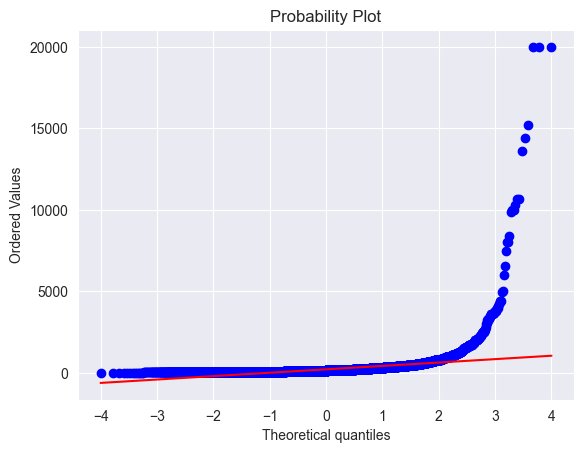

In [50]:
# === QQ플롯으로 price 분포 시각화 ===
print('=== price QQ plot ===')
stats.probplot(df['price'], dist="norm", plot=plt)
plt.show()

In [48]:
log_price_normality = assess_normality(df['log_price'])

표본 수 n = 22308
왜도 skew (정규분포 0) = 0.568
초과 첨도 excess kurtosis (정규분포 0) = 1.044
D'Agostino K² p = 0.000
Jarque–Bera p   = 0.000
Lilliefors p     = 0.001
Anderson stat    = 44.504
  Crit @ 15.0% = 0.576  -> Reject
  Crit @ 10.0% = 0.656  -> Reject
  Crit @ 5.0% = 0.787  -> Reject
  Crit @ 2.5% = 0.918  -> Reject
  Crit @ 1.0% = 1.092  -> Reject

정규성으로 볼 수 있을까? False  (skew<0.5 & |kurt|<1 rule)


=== log price QQ plot ===


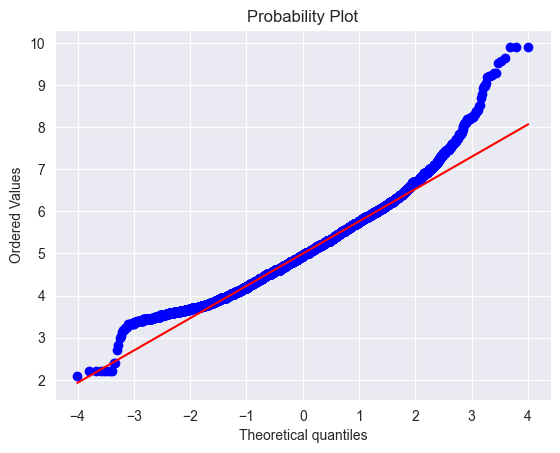

In [49]:
print('=== log price QQ plot ===')
stats.probplot(df['log_price'].dropna(), dist='norm', plot=plt)
plt.show()

In [67]:
# -----------------------------------
# room_type과 price 간의 연관성 가설검정
# -----------------------------------
alpha = 0.05
max_shapiro_n = 5000 # 이보다 크면 Shapiro 신뢰↓ -> 샘플 or skip

X = 'room_type'
y = 'log_price'

# 가설 수립
h0 = 'room_type 그룹 간 가격 차이는 없을 것이다'
h1 = '적어도 한 개 이상의 room_type 그룹 간 가격 차이가 있을 것이다'

print("=== 가설 검정 ===")
print(f"독립변수 X: {X}")
print(f"종속변수 y: {y}")
print(f"귀무가설 H0: {h0}")
print(f"대립가설 H1: {h1}")

res = decide_group_stat_test(df, X, y)
print(res['recommend'])

=== 가설 검정 ===
독립변수 X: room_type
종속변수 y: log_price
귀무가설 H0: room_type 그룹 간 가격 차이는 없을 것이다
대립가설 H1: 적어도 한 개 이상의 room_type 그룹 간 가격 차이가 있을 것이다

=== 정규성, 등분산성 검정 ===

[그룹별 정규성 p-value]
| room_type       |     n |   shapiro_p |     k2_p |
|-----------------|-------|-------------|----------|
| Entire home/apt | 12664 |    3.54e-33 | 0        |
| Private room    |  9186 |    5.23e-47 | 0        |
| Hotel room      |   372 |    2.29e-13 | 8.93e-22 |
| Shared room     |    86 |    0.0016   | 0.0018   |

Levene p-value = 5.04e-15
→ Kruskal-Wallis + Dunn(보정) 권장.
kruskal



=== Kruskal–Wallis: log_price ~ room_type ===
사용 그룹: 4개 (min_n=2)
Kruskal–Wallis H = 7268.6951, p-value = 0
H0: room_type 그룹 간 log_price 분포(중앙위치)에 차이가 없다.
H1: 적어도 한 room_type 그룹의 log_price 분포가 다르다.
p-value < 0.05 → 귀무가설 기각. Dunn 사후(holm) 진행.

=== Dunn 다중비교 (holm 보정) ===
+-----------------+-------------------+--------------+----------------+---------------+
|                 |   Entire home/apt |   Hotel room |   Private room |   Shared room |
|-----------------+-------------------+--------------+----------------+---------------|
| Entire home/apt |            1.0000 |       0.0000 |         0.0000 |        0.0000 |
| Hotel room      |            0.0000 |       1.0000 |         0.0000 |        0.0000 |
| Private room    |            0.0000 |       0.0000 |         1.0000 |        0.8765 |
| Shared room     |            0.0000 |       0.0000 |         0.8765 |        1.0000 |
+-----------------+-------------------+--------------+----------------+---------------+

=== 유의한 그룹 쌍 (p < 0.05)

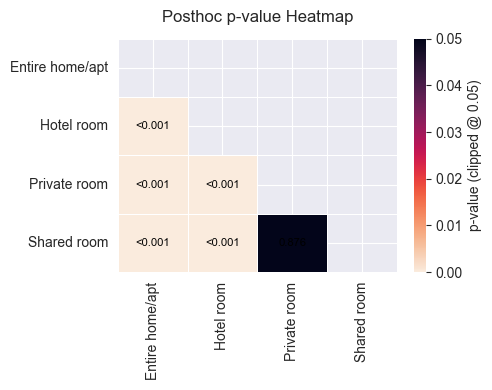

In [77]:
# -----------------------------------
# room_type과 price 간의 연관성 가설검정
# -----------------------------------
res = kruskal_dunn(
    df,
    X=X,
    Y=y,
    alpha=alpha,
    adjust='holm',   # 'bonf', 'holm', 'fdr'
    verbose=True
)

if res['pvals_matrix'] is not None:
    p_heatmap(
        res['pvals_matrix'],
        alpha=alpha,
        clip_upper=0.05,
        annot_mode="p",    # 숫자 표시
        cmap="rocket_r",      # 푸른 계열
        text_color="black",
    )

In [81]:
# -------------------------------------
# structure_type과 price 간의 연관성 가설검정
# -------------------------------------
alpha = 0.05
max_shapiro_n = 5000 # 이보다 크면 Shapiro 신뢰↓ -> 샘플 or skip

X = 'structure_type'
y = 'log_price'

# 가설 수립
h0 = 'structure type 그룹 간 가격 차이는 없을 것이다'
h1 = '적어도 한 개 이상의 structure type 그룹 간 가격 차이가 있을 것이다'

print("=== 가설 검정 ===")
print(f"독립변수 X: {X}")
print(f"종속변수 y: {y}")
print(f"귀무가설 H0: {h0}")
print(f"대립가설 H1: {h1}")

res = decide_group_stat_test(df, X, y)
print(res['recommend'])

=== 가설 검정 ===
독립변수 X: structure_type
종속변수 y: log_price
귀무가설 H0: structure type 그룹 간 가격 차이는 없을 것이다
대립가설 H1: 적어도 한 개 이상의 structure type 그룹 간 가격 차이가 있을 것이다

=== 정규성, 등분산성 검정 ===

[그룹별 정규성 p-value]
| structure_type     |     n |   shapiro_p |        k2_p |
|--------------------|-------|-------------|-------------|
| rental unit        | 14924 |    9.81e-22 |   6.92e-104 |
| home               |  2959 |    3.44e-32 |   2.57e-121 |
| condo              |  1036 |    1.7e-15  |   4.97e-30  |
| townhouse          |   964 |    8.28e-14 |   2.77e-10  |
| hotel              |   814 |    2.66e-14 |   3.26e-24  |
| guest suite        |   387 |    6.23e-10 |   1.1e-19   |
| loft               |   354 |    7.22e-10 |   7.2e-12   |
| serviced apartment |   217 |    0.000461 |   0.0852    |
| boutique hotel     |   212 |    1.94e-08 |   0.000199  |
| place              |    61 |    4.84e-07 |   1e-05     |
| bed and breakfast  |    60 |    0.0318   |   0.0495    |
| aparthotel         |    57 |    9.16e


=== Kruskal–Wallis: log_price ~ structure_type ===
사용 그룹: 27개 (min_n=2)
제외된 소표본 그룹(4): barn, dome, kezhan, ranch
Kruskal–Wallis H = 1675.1606, p-value = 0
H0: structure_type 그룹 간 log_price 분포(중앙위치)에 차이가 없다.
H1: 적어도 한 structure_type 그룹의 log_price 분포가 다르다.
p-value < 0.05 → 귀무가설 기각. Dunn 사후(holm) 진행.

=== Dunn 다중비교 (holm 보정) ===
+--------------------+--------------+---------------------+--------+------------------+------------+-------------+-------------------+---------+-----------+----------------+---------------+--------------+--------+----------+---------+-------------+--------+---------+----------------------+---------------+----------+----------------------+-------------+---------+-------------+-----------------+---------+
|                    |   aparthotel |   bed and breakfast |   boat |   boutique hotel |   bungalow |   camper/rv |   casa particular |   condo |   cottage |   earthen home |   guest suite |   guesthouse |   home |   hostel |   hotel |   houseboat |   loft |   plac

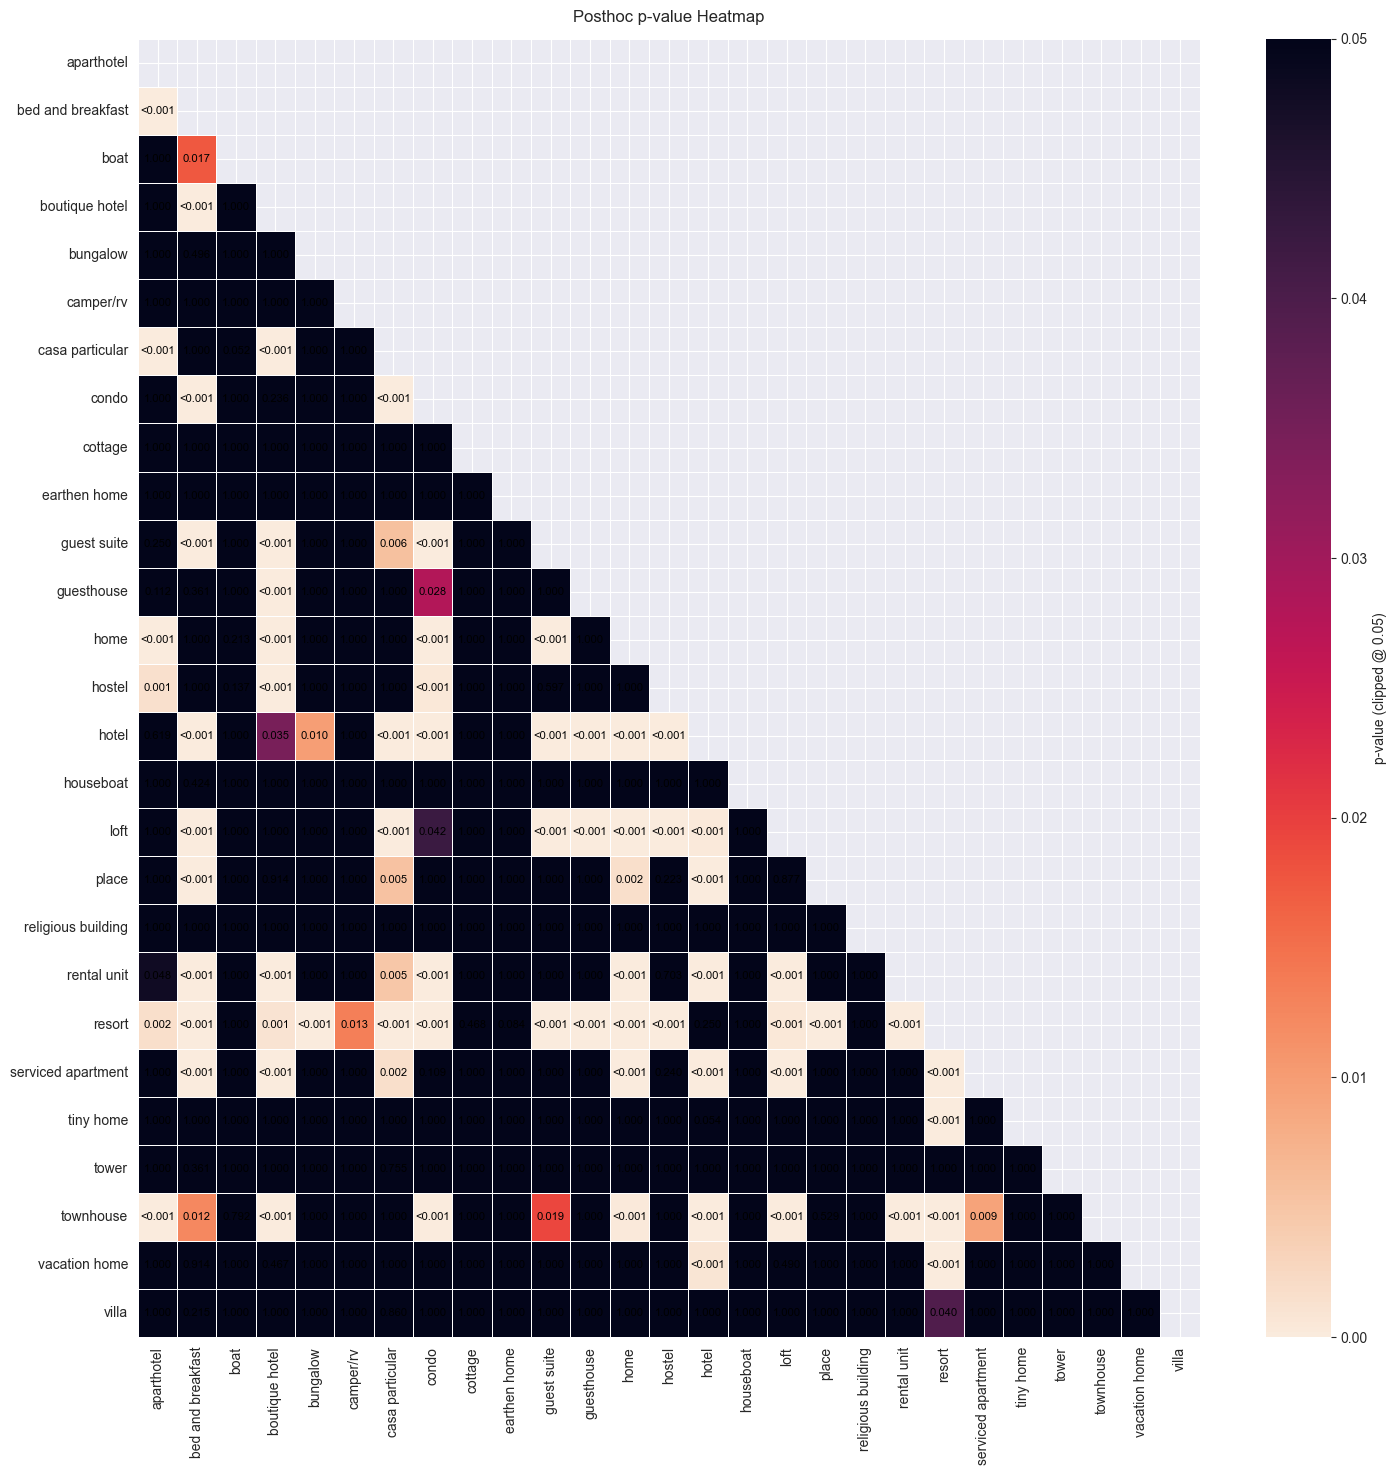

In [82]:
# -------------------------------------
# structure_type과 price 간의 연관성 가설검정
# -------------------------------------
res = kruskal_dunn(
    df,
    X=X,
    Y=y,
    alpha=alpha,
    adjust='holm',   # 'bonf', 'holm', 'fdr'
    verbose=True
)

if res['pvals_matrix'] is not None:
    p_heatmap(
        res['pvals_matrix'],
        alpha=alpha,
        clip_upper=0.05,
        annot_mode="p",    # 숫자 표시
        cmap="rocket_r",      # 푸른 계열
        text_color="black",
    )

In [83]:
# ---------------------------------------------------
# neighbourhood_group_cleansed과 price 간의 연관성 가설검정
# ---------------------------------------------------
alpha = 0.05
max_shapiro_n = 5000 # 이보다 크면 Shapiro 신뢰↓ -> 샘플 or skip

X = 'neighbourhood_group_cleansed'
y = 'log_price'

# 가설 수립
h0 = 'neighbourhood_group_cleansed 그룹 간 가격 차이는 없을 것이다'
h1 = '적어도 한 개 이상의 neighbourhood_group_cleansed 그룹 간 가격 차이가 있을 것이다'

print("=== 가설 검정 ===")
print(f"독립변수 X: {X}")
print(f"종속변수 y: {y}")
print(f"귀무가설 H0: {h0}")
print(f"대립가설 H1: {h1}")

res = decide_group_stat_test(df, X, y)
print(res['recommend'])

=== 가설 검정 ===
독립변수 X: neighbourhood_group_cleansed
종속변수 y: log_price
귀무가설 H0: neighbourhood_group_cleansed 그룹 간 가격 차이는 없을 것이다
대립가설 H1: 적어도 한 개 이상의 neighbourhood_group_cleansed 그룹 간 가격 차이가 있을 것이다

=== 정규성, 등분산성 검정 ===

[그룹별 정규성 p-value]
| neighbourhood_group_cleansed   |     n |   shapiro_p |     k2_p |
|--------------------------------|-------|-------------|----------|
| Manhattan                      | 10205 |    5.74e-23 | 1.8e-142 |
| Brooklyn                       |  7455 |    1.21e-26 | 8.9e-88  |
| Queens                         |  3420 |    1e-19    | 5.48e-38 |
| Bronx                          |   912 |    1.74e-17 | 5.71e-56 |
| Staten Island                  |   316 |    1.45e-08 | 8.71e-13 |

Levene p-value = 1.13e-56
→ Kruskal-Wallis + Dunn(보정) 권장.
kruskal



=== Kruskal–Wallis: log_price ~ neighbourhood_group_cleansed ===
사용 그룹: 5개 (min_n=2)
Kruskal–Wallis H = 3021.9059, p-value = 0
H0: neighbourhood_group_cleansed 그룹 간 log_price 분포(중앙위치)에 차이가 없다.
H1: 적어도 한 neighbourhood_group_cleansed 그룹의 log_price 분포가 다르다.
p-value < 0.05 → 귀무가설 기각. Dunn 사후(holm) 진행.

=== Dunn 다중비교 (holm 보정) ===
+---------------+---------+------------+-------------+----------+-----------------+
|               |   Bronx |   Brooklyn |   Manhattan |   Queens |   Staten Island |
|---------------+---------+------------+-------------+----------+-----------------|
| Bronx         |  1.0000 |     0.0000 |      0.0000 |   0.0026 |          0.1068 |
| Brooklyn      |  0.0000 |     1.0000 |      0.0000 |   0.0000 |          0.0000 |
| Manhattan     |  0.0000 |     0.0000 |      1.0000 |   0.0000 |          0.0000 |
| Queens        |  0.0026 |     0.0000 |      0.0000 |   1.0000 |          0.9747 |
| Staten Island |  0.1068 |     0.0000 |      0.0000 |   0.9747 |          1.0000 |

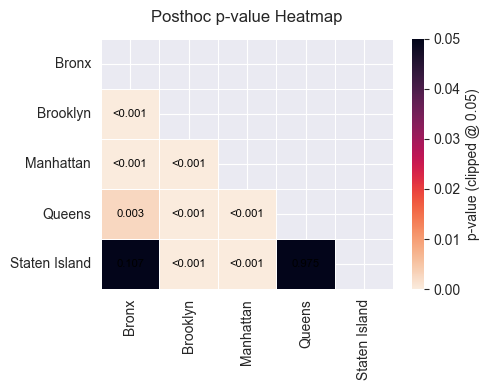

In [84]:
# ---------------------------------------------------
# neighbourhood_group_cleansed과 price 간의 연관성 가설검정
# ---------------------------------------------------
res = kruskal_dunn(
    df,
    X=X,
    Y=y,
    alpha=alpha,
    adjust='holm',   # 'bonf', 'holm', 'fdr'
    verbose=True
)

if res['pvals_matrix'] is not None:
    p_heatmap(
        res['pvals_matrix'],
        alpha=alpha,
        clip_upper=0.05,
        annot_mode="p",    # 숫자 표시
        cmap="rocket_r",      # 푸른 계열
        text_color="black",
    )

In [85]:
# ---------------------------------------------------
# neighbourhood_cleansed과 price 간의 연관성 가설검정
# ---------------------------------------------------
alpha = 0.05
max_shapiro_n = 5000 # 이보다 크면 Shapiro 신뢰↓ -> 샘플 or skip

X = 'neighbourhood_cleansed'
y = 'log_price'

# 가설 수립
h0 = 'neighbourhood_cleansed 그룹 간 가격 차이는 없을 것이다'
h1 = '적어도 한 개 이상의 neighbourhood_cleansed 그룹 간 가격 차이가 있을 것이다'

print("=== 가설 검정 ===")
print(f"독립변수 X: {X}")
print(f"종속변수 y: {y}")
print(f"귀무가설 H0: {h0}")
print(f"대립가설 H1: {h1}")

res = decide_group_stat_test(df, X, y)
print(res['recommend'])

=== 가설 검정 ===
독립변수 X: neighbourhood_cleansed
종속변수 y: log_price
귀무가설 H0: neighbourhood_cleansed 그룹 간 가격 차이는 없을 것이다
대립가설 H1: 적어도 한 개 이상의 neighbourhood_cleansed 그룹 간 가격 차이가 있을 것이다

=== 정규성, 등분산성 검정 ===

[그룹별 정규성 p-value]
| neighbourhood_cleansed    |    n |   shapiro_p |       k2_p |
|---------------------------|------|-------------|------------|
| Bedford-Stuyvesant        | 1545 |    2.41e-14 |   4.5e-05  |
| Midtown                   | 1461 |    3.43e-18 |   3.08e-40 |
| Upper East Side           | 1042 |    3.66e-25 |   1.28e-54 |
| Hell's Kitchen            | 1036 |    8.73e-09 |   3.67e-08 |
| Harlem                    | 1031 |    3.89e-15 |   8.41e-26 |
| Upper West Side           |  929 |    2.37e-11 |   3.55e-08 |
| Williamsburg              |  853 |    3.94e-07 |   0.0035   |
| Bushwick                  |  758 |    3.29e-14 |   1.19e-21 |
| Crown Heights             |  648 |    6.71e-13 |   1.81e-25 |
| Chelsea                   |  520 |    5.63e-06 |   0.000825 |
| East Village

In [86]:
# ---------------------------------------------------
# neighbourhood_cleansed과 price 간의 연관성 가설검정
# ---------------------------------------------------
res = kruskal_dunn(
    df,
    X=X,
    Y=y,
    alpha=alpha,
    adjust='holm',   # 'bonf', 'holm', 'fdr'
    verbose=True
)

if res['pvals_matrix'] is not None:
    p_heatmap(
        res['pvals_matrix'],
        alpha=alpha,
        clip_upper=0.05,
        annot_mode="p",    # 숫자 표시
        cmap="rocket_r",      # 푸른 계열
        text_color="black",
    )


=== Kruskal–Wallis: log_price ~ neighbourhood_cleansed ===
사용 그룹: 217개 (min_n=2)
제외된 소표본 그룹(4): Chelsea, Staten Island, Fort Wadsworth, Oakwood, Willowbrook
Kruskal–Wallis H = 6511.4088, p-value = 0
H0: neighbourhood_cleansed 그룹 간 log_price 분포(중앙위치)에 차이가 없다.
H1: 적어도 한 neighbourhood_cleansed 그룹의 log_price 분포가 다르다.
p-value < 0.05 → 귀무가설 기각. Dunn 사후(holm) 진행.

=== Dunn 다중비교 (holm 보정) ===
+---------------------------+------------+-----------------+------------+-----------+-----------+--------------+---------------------+-------------+---------------+--------------+-----------+-------------+----------------------+----------------+-------------+-----------+---------------+----------------+---------------+----------------+----------------+-------------+------------------+-------------+--------------------+---------------+---------------+------------+-------------------+------------+-------------------+---------------+---------------------+-----------+-------------+---------------+-----------